In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np

import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker
from cartopy.util import add_cyclic_point
from matplotlib.patches import Rectangle
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
path='/groups/XDU5/CMIP6_PMIP4/CESM2/piControl/'
file='merged.nc'

In [3]:
ds = xr.open_dataset(path+file)
ds

<xarray.Dataset> Size: 933MB
Dimensions:    (time: 3600, bnds: 2, lon: 360, lat: 180)
Coordinates:
  * time       (time) object 29kB 0001-01-15 13:00:00 ... 0300-12-15 12:00:00
  * lon        (lon) float64 3kB 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
  * lat        (lat) float64 1kB -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) object 58kB ...
    lon_bnds   (lon, bnds) float64 6kB ...
    lat_bnds   (lat, bnds) float64 3kB ...
    tos        (time, lat, lon) float32 933MB ...
Attributes: (12/44)
    CDI:                    Climate Data Interface version 1.9.10 (https://mp...
    source:                 CESM2 (2017): atmosphere: CAM6 (0.9x1.25 finite v...
    institution:            National Center for Atmospheric Research
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            ISMIP6
    branch_method:          no parent
    ...                     ...
    tracking_id:            hdl:21.14100/5b4f3620-4efa-4fc4-a257-421bd31448b9
    variable_id:            tos
    variant_info:           CMIP6 ISMIP6 CESM2 piControl-withism experiment w...
    variant_label:          r1i1p1f1
    history:                Sun Sep 08 20:46:50 2024: cdo mergetime tos_Omon_...
    CDO:                    Climate Data Operators version 1.9.10 (https://mp...

In [4]:
#getting the last 200 years that reaches almost the equilibrium state in the simulation
ds_200 = ds.sel(time=slice("0100-12-15 13:00:00", "0300-12-15 13:00:00"))
ds_200

<xarray.Dataset> Size: 622MB
Dimensions:    (time: 2400, bnds: 2, lon: 360, lat: 180)
Coordinates:
  * time       (time) object 19kB 0101-01-15 12:00:00 ... 0300-12-15 12:00:00
  * lon        (lon) float64 3kB 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
  * lat        (lat) float64 1kB -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) object 38kB ...
    lon_bnds   (lon, bnds) float64 6kB ...
    lat_bnds   (lat, bnds) float64 3kB ...
    tos        (time, lat, lon) float32 622MB ...
Attributes: (12/44)
    CDI:                    Climate Data Interface version 1.9.10 (https://mp...
    source:                 CESM2 (2017): atmosphere: CAM6 (0.9x1.25 finite v...
    institution:            National Center for Atmospheric Research
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            ISMIP6
    branch_method:          no parent
    ...                     ...
    tracking_id:            hdl:21.14100/5b4f3620-4efa-4fc4-a257-421bd31448b9
    variable_id:            tos
    variant_info:           CMIP6 ISMIP6 CESM2 piControl-withism experiment w...
    variant_label:          r1i1p1f1
    history:                Sun Sep 08 20:46:50 2024: cdo mergetime tos_Omon_...
    CDO:                    Climate Data Operators version 1.9.10 (https://mp...

In [5]:
#getting monthly gloabl SST anomalies
ds_climo = ds_200.groupby('time.month').mean()
ds_anoms = ds_200.groupby('time.month')-ds_climo
ds_anoms

<xarray.Dataset> Size: 643MB
Dimensions:   (time: 2400, lon: 360, lat: 180, bnds: 2)
Coordinates:
  * time      (time) object 19kB 0101-01-15 12:00:00 ... 0300-12-15 12:00:00
  * lon       (lon) float64 3kB 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
  * lat       (lat) float64 1kB -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
    month     (time) int64 19kB 1 2 3 4 5 6 7 8 9 10 ... 3 4 5 6 7 8 9 10 11 12
Dimensions without coordinates: bnds
Data variables:
    lon_bnds  (time, lon, bnds) float64 14MB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    lat_bnds  (time, lat, bnds) float64 7MB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    tos       (time, lat, lon) float32 622MB nan nan nan ... -0.003111 -0.003129

In [6]:
#creating Niño indices
def get_index(p,q,r,s):
    nino = ds_anoms.sel(lat=slice(p,q), lon=slice(360-r,360-s))
    return nino.mean(dim=["lon", "lat"])

#Niño1+2
nino12 = get_index(-10,0,90,80)
#Niño3
nino3 = get_index(-5,5,150,90)
#Niño3.4
nino34 = get_index(-5,5,170,120)
#Niño4
nino4 = get_index(-5,5,200,150)

In [7]:
#getting El Niño, La Niña, and Neutral years
def get_enso(x):
    elnino = x["tos"].where(x["tos"]>0.5) #El Nino
    lanina = x["tos"].where(x["tos"]<-0.5) #La Nina
    neutral = x["tos"].where(np.logical_and(x["tos"]>=-0.5, 
                                            x["tos"]<=0.5)) #neutral
    return [elnino,lanina,neutral]

enso12 = get_enso(nino12)
enso3 = get_enso(nino3)
enso34 = get_enso(nino34)
enso4 = get_enso(nino4)

In [8]:
#getting global SST in the same time period as nino indices
def global_sst(x):
    sst = ds.tos.sel(time=slice(x['time'][0], x['time'][-1]))
    sst_climo = sst.groupby('time.month').mean()
    return sst.groupby('time.month')-sst_climo

sst_anoms12 = global_sst(nino12)
sst_anoms3 = global_sst(nino3)
sst_anoms34 = global_sst(nino34)
sst_anoms4 = global_sst(nino4)

In [9]:
#getting composits
def get_composit(p,x,y,z):
    elnino_sst = p.sel(time=x.dropna(dim='time')['time']).mean(dim='time')
    lanina_sst = p.sel(time=y.dropna(dim='time')['time']).mean(dim='time')
    neutral_sst = p.sel(time=z.dropna(dim='time')['time']).mean(dim='time')
    return [elnino_sst,lanina_sst,neutral_sst]

comp_sst12 = get_composit(sst_anoms12,enso12[0],enso12[1],enso12[2])
comp_sst3 = get_composit(sst_anoms3,enso3[0],enso3[1],enso3[2])
comp_sst34 = get_composit(sst_anoms34,enso34[0],enso34[1],enso34[2])
comp_sst4 = get_composit(sst_anoms4,enso4[0],enso4[1],enso4[2])

Text(0.5, 3.7, 'Niño Index Regions')

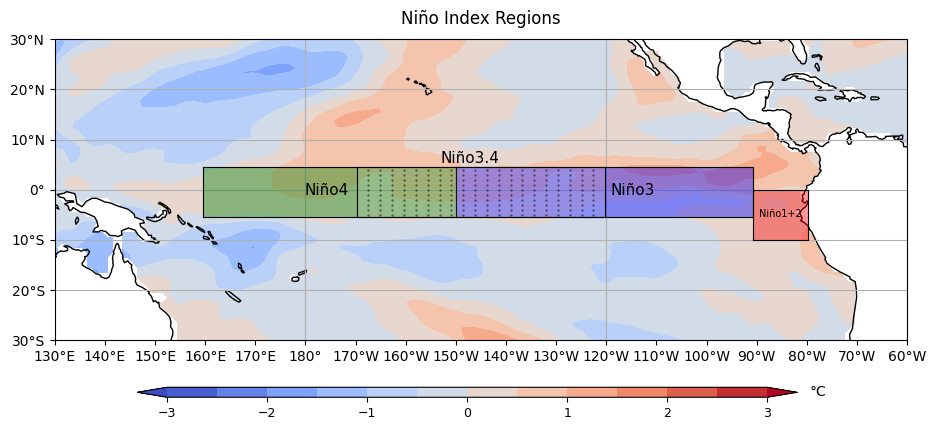

In [10]:
#Nino index regions 

clevs = np.arange(-3,3.1,0.5)
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)},
                        figsize=(11,5))
#the tropical pacific
ax.set_extent([130, 300, -30, 30], crs=ccrs.PlateCarree())
#data plot
cs=ax.contourf(ds.lon, ds.lat, sst_anoms34[1,:,:], levels=clevs,
            transform = ccrs.PlateCarree(),cmap='coolwarm',extend='both') 
#longitude labels
ax.set_xticks(np.arange(130,301,10), crs=ccrs.PlateCarree())
lon_formatter = cticker.LongitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.gridlines()
# Latitude labels
ax.set_yticks(np.arange(-30,31,10), crs=ccrs.PlateCarree())
lat_formatter = cticker.LatitudeFormatter()
ax.yaxis.set_major_formatter(lat_formatter)
#coastlines
ax.coastlines()
# Add a colorbar axis at the bottom of the graph
cbar_ax = fig.add_axes([0.2, 0.08, 0.6, 0.02])
# Draw the colorbar
cbar=fig.colorbar(cs, cax=cbar_ax,orientation='horizontal',label=None)
cbar_ax.tick_params(labelsize=9) 
cbar_ax.text(1.07,0.1,"\u00b0C", transform=cbar.ax.transAxes)
# Add an axis 
ax12 = fig.add_axes([0.76, 0.395, 0.05, 0.1])
ax12.text(0.1,0.45,"Niño1+2",fontsize=7) 
ax12.tick_params(left=False, right=False, top=False, bottom=False, labelleft=False, labelbottom=False)
ax12.set_facecolor('red') 
ax12.patch.set_alpha(0.4)
ax3 = fig.add_axes([0.49, 0.44, 0.27, 0.1])
ax3.text(0.52,0.45,"Niño3",fontsize=11) 
ax3.tick_params(left=False, right=False, top=False, bottom=False, labelleft=False, labelbottom=False)
ax3.set_facecolor('blue') 
ax3.patch.set_alpha(0.4)
ax4 = fig.add_axes([0.26, 0.44, 0.23, 0.1])
ax4.text(0.4,0.45,"Niño4",fontsize=11) 
ax4.tick_params(left=False, right=False, top=False, bottom=False, labelleft=False, labelbottom=False)
ax4.set_facecolor('green') 
ax4.patch.set_alpha(0.4)
ax34 = fig.add_axes([0.4, 0.44, 0.225, 0.1])
x = np.linspace(0, 1, 20) 
y = np.linspace(0, 1, 10) 
X, Y = np.meshgrid(x, y) # Plot dots (scatter) to fill the axis background
ax34.scatter(X, Y, color='black', s=0.1)  
ax34.text(0.32,1.15,"Niño3.4",fontsize=11)
ax34.tick_params(left=False, right=False, top=False, bottom=False, labelleft=False, labelbottom=False)
ax34.patch.set_alpha(0.1)
#title
plt.title('Niño Index Regions', y=3.7)

In [11]:
#plotting composit sst
def plot_composit(x,y,z):
    labels=['El Nino', 'La Nina', 'Neutral']
    ENSO = ["Nino1+2", "Nino3", "Nino3.4", "Nino4"]
    clevs = np.arange(-2,2.1,0.25)
    # Define the figure and each axis for the 3 rows and 3 columns
    fig, axs = plt.subplots(nrows=1,ncols=3,
                        subplot_kw={'projection': ccrs.PlateCarree(central_longitude=200)},
                        figsize=(11,5))
    axs = axs.flatten()
    
    for i,enso in enumerate(x):
        # Select the season
        data = x[i]
        # Add the cyclic point
        data,lons = add_cyclic_point(data,coord=x[i]['lon'])
        # Contour plot
        cs=axs[i].contourf(lons,x[i]['lat'],data,clevs,
                          transform = ccrs.PlateCarree(),
                          cmap='coolwarm',extend='both')
        # Longitude labels
        axs[i].set_xticks(np.arange(-180,181,60), crs=ccrs.PlateCarree())
        lon_formatter = cticker.LongitudeFormatter()
        axs[i].xaxis.set_major_formatter(lon_formatter)
        # Latitude labels
        axs[i].set_yticks(np.arange(-90,91,30), crs=ccrs.PlateCarree())
        lat_formatter = cticker.LatitudeFormatter()
        axs[i].yaxis.set_major_formatter(lat_formatter)        
        # Title each subplot with the name of the season
        axs[i].set_title(labels[i]+' ('+str(y[i].count(dim='time').values)+')')
        # Draw the coastines for each subplot
        axs[i].coastlines(zorder=3, color='grey')
        
    # Adjust the location of the subplots 
    # on the page to make room for the colorbar
    fig.subplots_adjust(bottom=None, top=None, left=0.05, right=0.95,
                    wspace=0.2, hspace=0.5)
    # Add a colorbar axis at the bottom of the graph
    cbar_ax = fig.add_axes([0.2, 0.22, 0.6, 0.02])
    # Draw the colorbar
    cbar=fig.colorbar(cs, cax=cbar_ax,orientation='horizontal',label=None)
    #cbar.ax.set_aspect(0.01)
    cbar_ax.tick_params(labelsize=9) 
    cbar_ax.text(1.07,0.1,"\u00b0C", transform=cbar.ax.transAxes)
    # Add a big title at the top
    plt.suptitle(f"Composite SST Anomalies during ENSO by {ENSO[z]}", y=0.75)

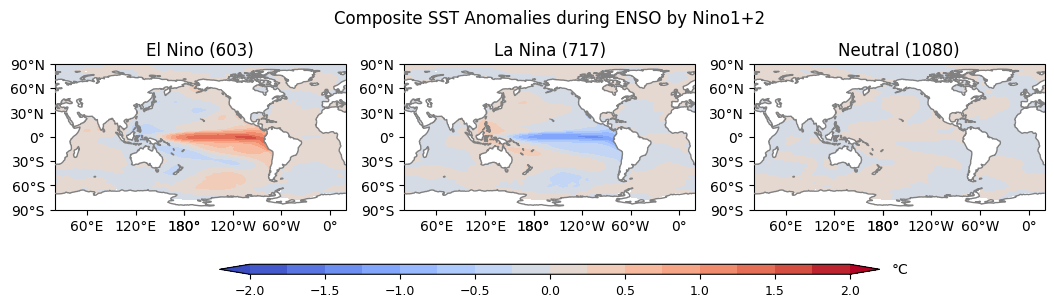

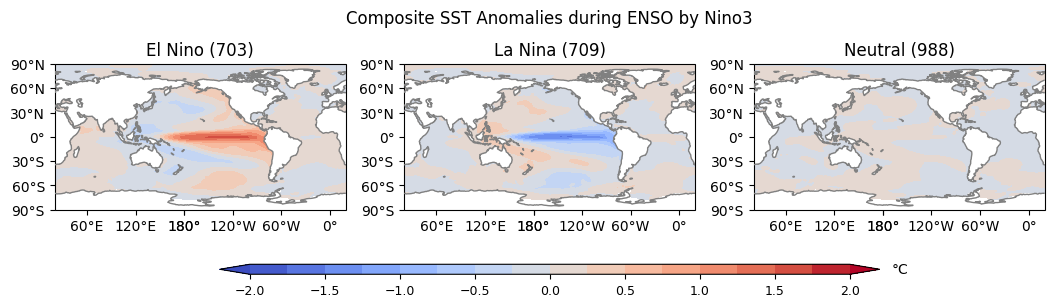

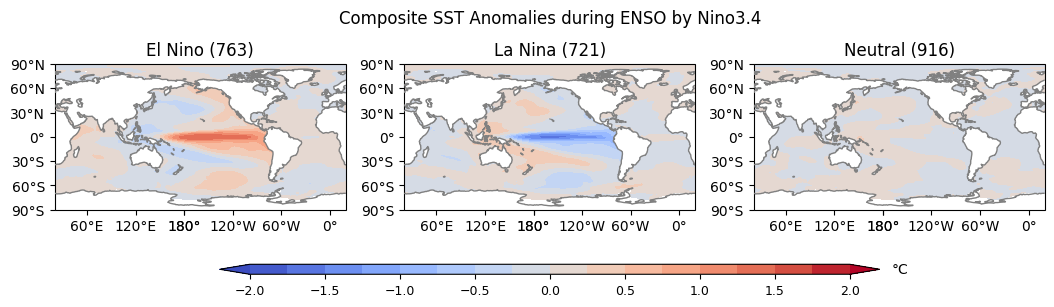

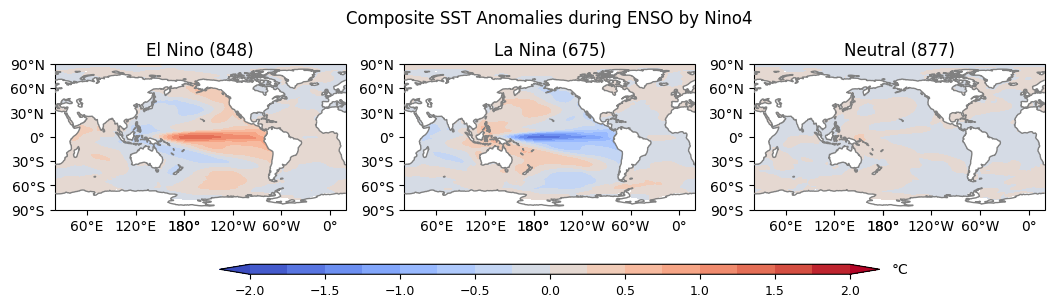

In [12]:
plot_composit(comp_sst12,enso12,0)
plot_composit(comp_sst3,enso3,1)
plot_composit(comp_sst34,enso34,2)
plot_composit(comp_sst4,enso4,3)

Computing linear regressions between each index's state (e.g. El Nino or La Nina) and global SST along the months

In [13]:
#C, or 5% statistical significance
from scipy.stats import linregress

def statis(x,y,z):
    elnino_sst = x.sel(time=y[0].dropna(dim="time")["time"]) #x=sst_anoms y=enso
    nino_ = z.sel(time=y[0].dropna(dim="time")["time"]) #z=nino
    lanina_sst = x.sel(time=y[1].dropna(dim="time")["time"])
    nina_ = z.sel(time=y[1].dropna(dim="time")["time"])
    nx = len(x["lon"])
    ny = len(x["lat"])
    
    # Create new empty arrays to contain the results of our calculations
    p_array_nino = np.zeros((ny,nx))   # The p-value (significance) of the fit of the regression
    r_array_nino = np.zeros((ny,nx))   # The correlation between the independent and dependent variables
    m_array_nino = np.zeros((ny,nx))   # The slope of the best-fit linear regression line
    p_array_nina = np.zeros((ny,nx))   
    r_array_nina = np.zeros((ny,nx))   
    m_array_nina = np.zeros((ny,nx))   
    
    nino_ = nino_["tos"] # The independent variable (predictor) nino12 elnino
    nina_ = nina_["tos"]
    
    #### Loop through all the grid cells in the global grid
    for j in range(ny):
        print(f"{j},",end=" ")
        for i in range(nx):
            y_nino = elnino_sst[:,j,i] # The dependent variable (predictand)
            y_nina = lanina_sst[:,j,i]
        
            m_nino,b_nino,r_nino,p_nino,e_nino = linregress(nino_,y_nino)   # b is intercept, e is standard error
            m_nina,b_nina,r_nina,p_nina,e_nina = linregress(nina_,y_nina)
        
            # Populate our new arrays with the results
            m_array_nino[j,i] = m_nino
            r_array_nino[j,i] = r_nino
            p_array_nino[j,i] = p_nino
            
            m_array_nina[j,i] = m_nina
            r_array_nina[j,i] = r_nina
            p_array_nina[j,i] = p_nina
        
    mask_sig_nino = np.where(p_array_nino<0.05, m_array_nino,np.nan) # NaNs where the signficance test fails
    mask_sig_nina = np.where(p_array_nina<0.05, m_array_nina,np.nan)
    
    return [elnino_sst, m_array_nino, mask_sig_nino], [lanina_sst, m_array_nina, mask_sig_nina]

nino_vars12, nina_vars12 = statis(sst_anoms12, enso12, nino12)
nino_vars3, nina_vars3 = statis(sst_anoms3, enso3, nino3)
nino_vars34, nina_vars34 = statis(sst_anoms34, enso34, nino34)
nino_vars4, nina_vars4 = statis(sst_anoms4, enso4, nino4)

0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 

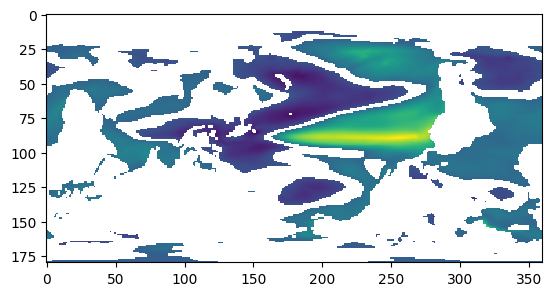

In [14]:
plt.imshow(nino_vars12[2])

In [15]:
def plot_stats(x,y,z):
    #color levels
    clevs=np.arange(-1.5,1.75,0.25)
    #labels
    labels=['El Nino', 'La Nina']
    ENSO = ["Nino1+2", "Nino3", "Nino3.4", "Nino4"]

    fig, ax = plt.subplots(nrows=1,ncols=2,
                           subplot_kw={'projection': ccrs.PlateCarree(central_longitude=200)},
                           figsize=(11,5))
    ax = ax.flatten()
    
    #nino_vars, nina_vars = statis(x,y,z)
    #dataset = [nino_vars, nina_vars]
    dataset = [x,y]
    
    for i,enso in enumerate(dataset):
        data_ = dataset[i]

        # Add cyclic point
        data = data_[1] #m_array
        data,lon = add_cyclic_point(data,coord=data_[0]['lon'])
        mask_data,lons = add_cyclic_point(data_[2],coord=data_[0]['lon'])

        # Make a filled contour plot
        cs = ax[i].contourf(lon,data_[0]['lat'], data,clevs,
                     transform=ccrs.PlateCarree(),
                     cmap='seismic',extend='both')
        
        ax[i].contourf(lon,data_[0]["lat"],mask_data,[0,1], 
                     transform = ccrs.PlateCarree(),colors='None',
                     hatches=['..','..'],extend='both',alpha=0)

        # Add coastlines
        ax[i].coastlines()

        # Define the xticks for longtitude 
        ax[i].set_xticks(np.arange(-180,181,60),crs=ccrs.PlateCarree())
        lon_formatter = cticker.LongitudeFormatter()
        ax[i].xaxis.set_major_formatter(lon_formatter)

        # Define ytick for latitude
        ax[i].set_yticks(np.arange(-90,91,30),crs=ccrs.PlateCarree())
        lat_formatter = cticker.LatitudeFormatter()
        ax[i].yaxis.set_major_formatter(lat_formatter)
        ax[i].set_title(labels[i])
    # the colorbar
    fig.subplots_adjust(bottom=None, top=None, left=0.05, right=0.95,
                    wspace=0.15, hspace=0.5)

    # Add a colorbar axis at the bottom
    cbar_ax = fig.add_axes([0.2, 0.17, 0.6, 0.02])
    
    # Draw the colorbar
    cbar = fig.colorbar(cs,cax=cbar_ax,orientation='horizontal', shrink=0.7,
                 label='Regression Coefficient')
    cbar_ax.tick_params(labelsize=9) 
    cbar_ax.text(1.07,0.3,"r", transform=cbar.ax.transAxes)
    
    # Add title
    plt.title(f'Regression between {ENSO[z]} and Global SST Anomalies', y=32)

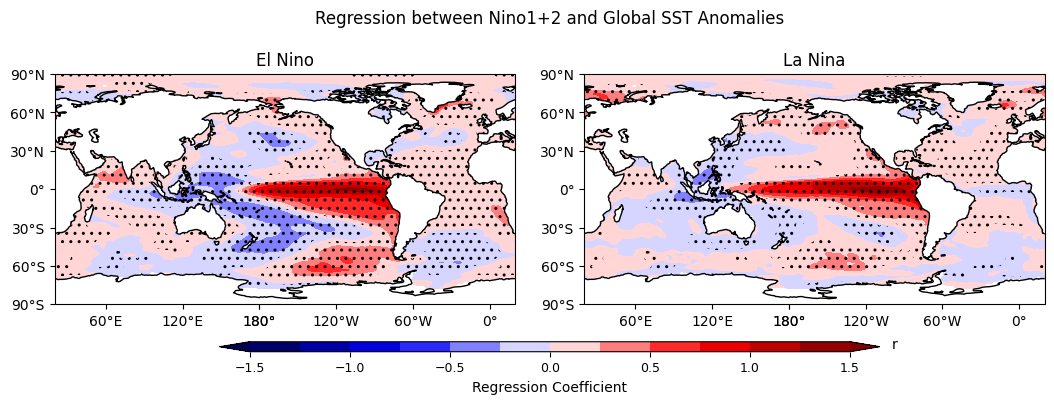

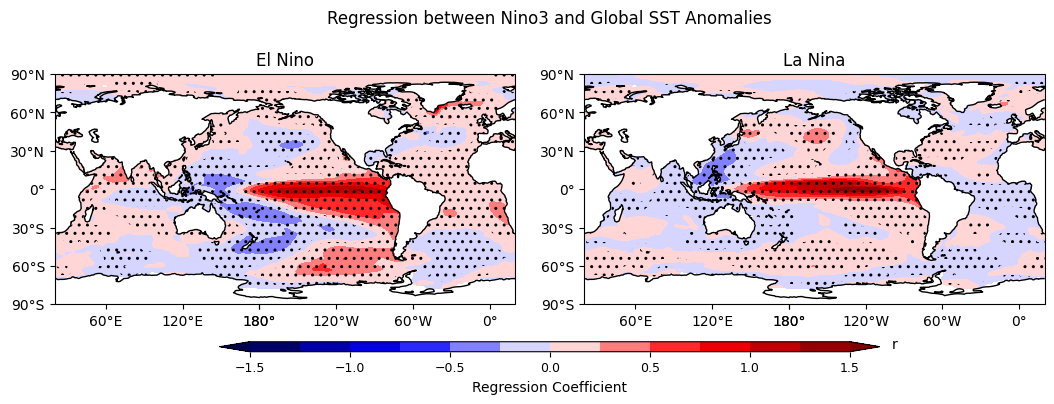

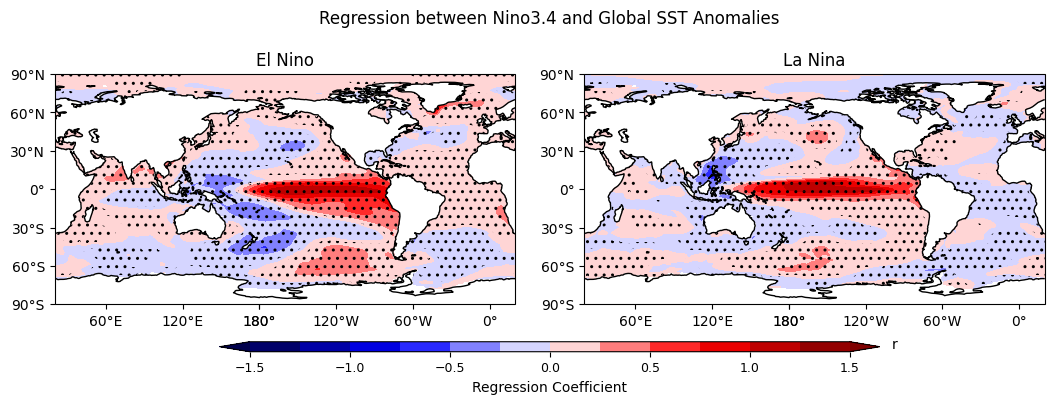

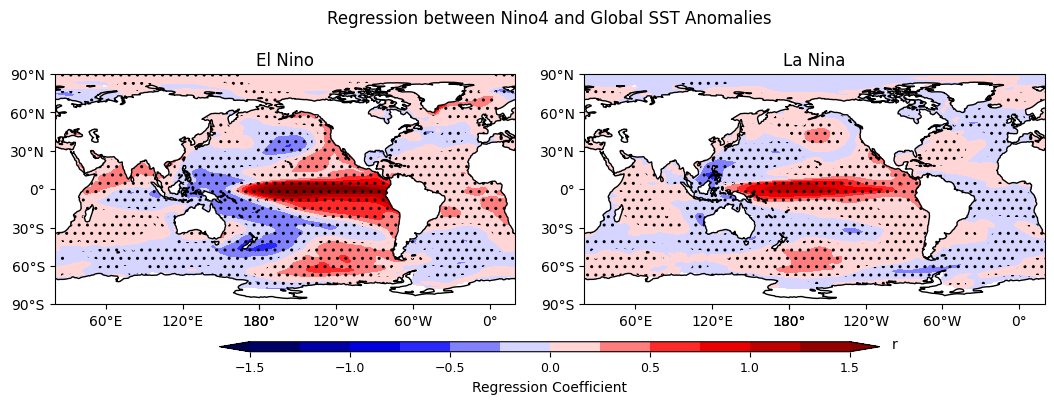

In [20]:
plot_stats(nino_vars12,nina_vars12,0)
plot_stats(nino_vars3,nina_vars3,1)
plot_stats(nino_vars34,nina_vars34,2)
plot_stats(nino_vars4,nina_vars4,3)

making a netcdf file

In [45]:
#create a DataArray

def create_data(x,y,z):
    ENSO = ["Nino1+2", "Nino3", "Nino3.4", "Nino4"]
    labels = ['El Nino', 'La Nina']
    
    r_pi = xr.DataArray(x[1], #nino_vars
                    coords={'lat':x[0]['lat'],
                            'lon':x[0]['lon']},
                    dims=['lat','lon'],
                    name='slope',
                    attrs={'name':'regression coefficient',
                           'units':'none',
                           'description':f'Linear regression of monthly SST anomaly against {ENSO[y]} index'})
    m_pi = xr.DataArray(x[2],
                    coords={'lat':x[0]['lat'],
                            'lon':x[0]['lon']},
                    dims=['lat','lon'],
                    name='mask',
                    attrs={'name':'masked SST',
                           'units':'\u2103',
                           'description':f'masked monthly SST anomaly against {ENSO[y]} {labels[z]}'})

    return xr.Dataset(data_vars={'sst':x[0],'slope':r_pi,'mask':m_pi})


In [61]:
#convert to a netcdf file
def converting(x,y,z,k):
    enso = ['12','3','34','4']
    regr = [create_data(x,z,0), create_data(y,z,1)] 
    regr[0].to_netcdf(f'{enso[k]}_el_pi.nc')
    regr[1].to_netcdf(f'{enso[k]}_la_pi.nc')

In [62]:
converting(nino_vars12,nina_vars12,0,0)

In [63]:
converting(nino_vars3,nina_vars3,1,1)
converting(nino_vars34,nina_vars34,2,2)
converting(nino_vars4,nina_vars4,3,3)

In [60]:
a = xr.open_dataset('12_el_pi.nc')
a

<xarray.Dataset> Size: 157MB
Dimensions:  (time: 603, lon: 360, lat: 180)
Coordinates:
  * time     (time) object 5kB 0101-05-15 12:00:00 ... 0298-12-15 12:00:00
  * lon      (lon) float64 3kB 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
  * lat      (lat) float64 1kB -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
    month    (time) int64 5kB ...
Data variables:
    sst      (time, lat, lon) float32 156MB ...
    slope    (lat, lon) float64 518kB ...
    mask     (lat, lon) float64 518kB ...